In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scIB

In [2]:
sc.logging.print_versions()

scanpy==1.4.5.dev114+gd69832a anndata==0.7.1 umap==0.3.9 numpy==1.17.0 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.22.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [9]:
plt.rcParams['figure.figsize'] = (12,12)

# User input

In [100]:
orig_file = '/storage/groups/ml01/workspace/group.daniela/immune_cells/Immune_ALL_human.h5ad'
#files = ['integration/unscaled/hvg/R/conos.h5ad', 'integration/scaled/hvg/scanorama.h5ad', 'integration/unscaled/hvg/R/seurat.h5ad', 'integration/unscaled/hvg/scanorama.h5ad', 'integration/scaled/hvg/mnn.h5ad']
best = ['integration/unscaled/hvg/R/conos.h5ad', 'integration/scaled/hvg/scanorama.h5ad', 'integration/scaled/hvg/mnn.h5ad', 'integration/unscaled/hvg/R/seurat.h5ad']
worst = ['integration/unscaled/full_feature/R/harmony.h5ad', 'integration/unscaled/hvg/R/liger.h5ad', 'integration/unscaled/full_feature/trvae.h5ad', 'integration/unscaled/full_feature/scvi.h5ad']
best_names = ['Conos (unscaled/hvg)', 'Scanorama(embedding) (scaled/hvg)', 'MNN (unscaled/hvg)', 'Seurat (unscaled/hvg)']
worst_names=['Harmony (unscaled/full feature)', 'Liger (unscaled/hvg)', 'trVAE (unscaled/full feature)', 'scIV (unscaled/full feature)']
best_types = ['knn', 'emb', 'gene', 'gene']
worst_types = ['emb', 'emb', 'gene', 'emb']
batch_key = 'batch'
ct_key = 'final_annotation'

In [149]:
#Lung atlas
base = '/storage/groups/ml01/workspace/scIB/lung_atlas/'
lung_pre = '/storage/groups/ml01/workspace/group.daniela/lung/Lung_atlas_final_fixed.h5ad'
lung_best = ['integration/unscaled/full_feature/R/conos.h5ad', 'integration/scaled/full_feature/scanorama.h5ad', 'integration/unscaled/hvg/R/seurat.h5ad', 'integration/scaled/hvg/mnn.h5ad']
lung_worst = ['integration/unscaled/full_feature/bbknn.h5ad','integration/unscaled/full_feature/trvae.h5ad', 'integration/unscaled/full_feature/scvi.h5ad', 'integration/unscaled/hvg/R/liger.h5ad']
lung_best_names = ['Conos (unscaled/full feature)', 'Scanorama (scaled/full feature)', 'Seurat (unscaled/hvg)', 'MNN (scaled/hvg)']
lung_worst_names = ['BBKNN (unscaled/full feature)', 'trVAE (unscaled/full feature)', 'scVI (unscaled/full feature)', 'LIGER (unscaled/hvg)']
lung_best_types = ['knn', 'emb', 'gene', 'gene']
lung_worst_types = ['knn', 'gene', 'emb', 'emb']
lung_batch = 'batch'
lung_ct = 'cell_type'


# Read files

In [136]:
def read_data(base, pre, best, worst, best_names, worst_names, best_types, worst_types):
    adata_pre = sc.read(pre)
    adatas_best = dict()
    adatas_worst = dict()
    for idx,file in enumerate(best):
        adatas_best[best_names[idx]] = (sc.read(base+file), best_types[idx])
    for idx,file in enumerate(worst):
        adatas_worst[worst_names[idx]] = (sc.read(base+file), worst_types[idx])
    return adata_pre, adatas_best, adatas_worst

In [6]:
# Transfer annotations from pervious object
def match_anns(adata, adata_pre, batch_key='batch'):
    # Match annotations:
    if len(set(adata_pre.obs_names).difference(set(adata.obs_names))) > 0:
        new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata.obs_names]
        if len(set(adata_pre.obs_names).difference(set(new_obs_names))) == 0:
            adata.obs_names = new_obs_names
        else:
            raise ValueError('obs_names changed after integration!')

    adata.obs[batch_key] = adata.obs[batch_key].astype('category')

    if not np.array_equal(adata_pre.obs[batch_key].cat.categories,adata.obs[batch_key].cat.categories):
        adata.obs[batch_key] = adata_pre.obs[batch_key]


In [147]:
# Preprocessing loop
def pp(adatas, a_pre):
    for key in adatas:
        print(f'preprocessing {key}...')
        ot = adatas[key][1]
        dat = adatas[key][0]
    
        # Ensure annotations are matched
        match_anns(dat, a_pre, batch_key)
    
        if ot == 'knn':
            if 'params' not in dat.uns['neighbors']:
                dat.uns['neighbors']['params'] = dict(n_pcs=dat.obsm['X_pca'].shape[1],
                                                      use_rep='X_pca',
                                                      metric='cosine',
                                                      method='umap',
                                                      n_neighbors=10)
            
            sc.tl.umap(dat)
        
        elif ot == 'emb':
            scIB.pp.reduce_data(dat, n_top_genes=None, neighbors=True, use_rep='X_emb', pca=True, umap=True)
        
        elif ot == 'gene':
            if key.startswith('tr'):
                sc.pp.filter_genes(dat, min_cells=1)
            scIB.pp.reduce_data(dat, n_top_genes=2000, neighbors=True, use_rep='X_pca', pca=True, umap=True)
        if key.startswith('Conos'):
            sc.tl.draw_graph(dat)

In [108]:
# Visualization loop
def viz(adatas_best, adatas_worst, var):
    fig, axs = plt.subplots(2, 4, figsize=(40,16))
    start = 0
    for key in adatas_best:
        dat = adatas_best[key][0]
        if key.startswith('Con'):
            sc.pl.draw_graph(dat, color=var, size=20, title=key, legend_loc="", ax=axs[0,start], show=False, frameon=False)
        else:
            sc.pl.umap(dat, color=var, size=20, title=key, legend_loc="", ax=axs[0,start], show=False, frameon=False)
        start+=1
    start=0
    for key in adatas_worst:
        dat = adatas_worst[key][0]

        sc.pl.umap(dat, color=var, size=20, title=key, legend_loc="", ax=axs[1,start], show=False, frameon=False)
        start+=1
    plt.savefig('figures/integrated.svg')
        #sc.pl.umap(dat, color=ct_key, size=20, title=key)

In [146]:
def draw_figure(base, pre, best, worst, best_names, worst_names, best_types, worst_types, batch, ct):
    a_pre, a_best, a_worst = read_data(base, pre, best, worst, best_names, worst_names, best_types, worst_types)
    print('Data reading successful')
    scIB.pp.reduce_data(a_pre, n_top_genes=2000, neighbors=True, use_rep='X_pca', pca=True, umap=True)
    pp(a_best, a_pre)
    pp(a_worst, a_pre)
    sc.pl.umap(a_pre, color=batch, frameon=False)
    viz(a_best, a_worst, batch)
    sc.pl.umap(a_pre, color=ct, frameon=False)
    viz(a_best, a_worst, ct)

Data reading successful
HVG
Calculating 2000 HVGs for reduce_data.
Computed 1999 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP
preprocessing Conos (unscaled/full feature)...
preprocessing Scanorama (scaled/full feature)...
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


preprocessing Seurat (unscaled/hvg)...
HVG
Calculating 2000 HVGs for reduce_data.
Computed 2000 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP
preprocessing MNN (scaled/hvg)...
HVG
Calculating 2000 HVGs for reduce_data.
Computed 1999 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP
preprocessing BBKNN (unscaled/full feature)...
preprocessing trVAE (unscaled/full feature)...
HVG
Calculating 2000 HVGs for reduce_data.
Computed 2000 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


preprocessing scVI (unscaled/full feature)...
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP
preprocessing LIGER (unscaled/hvg)...
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


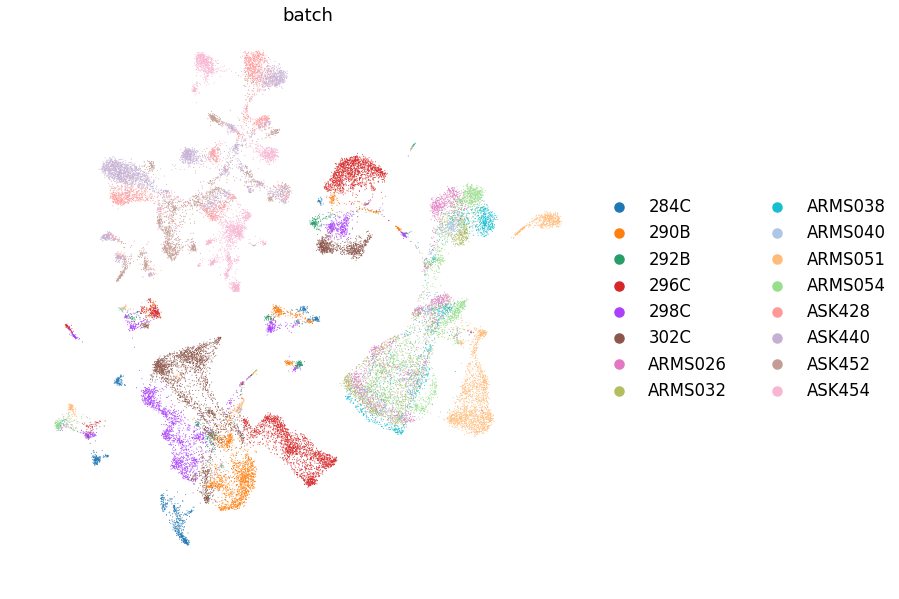

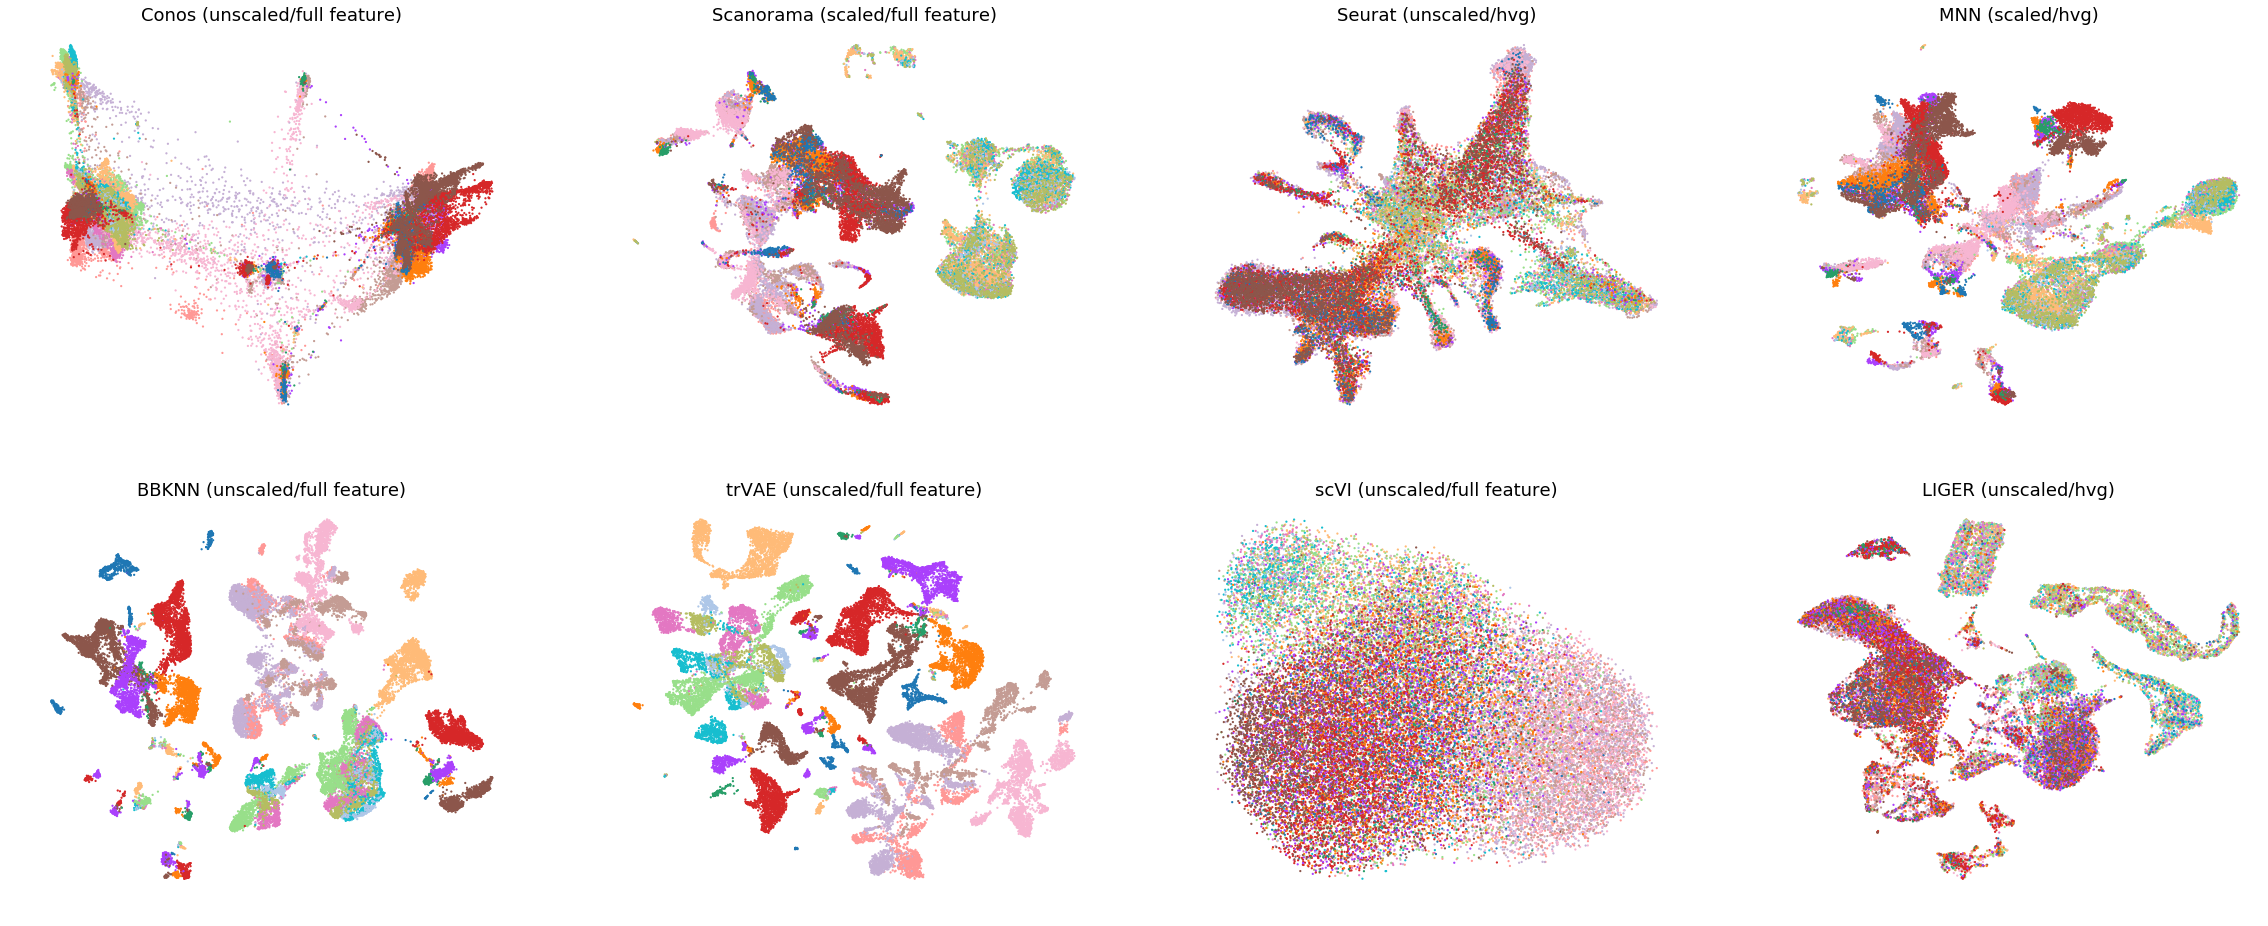

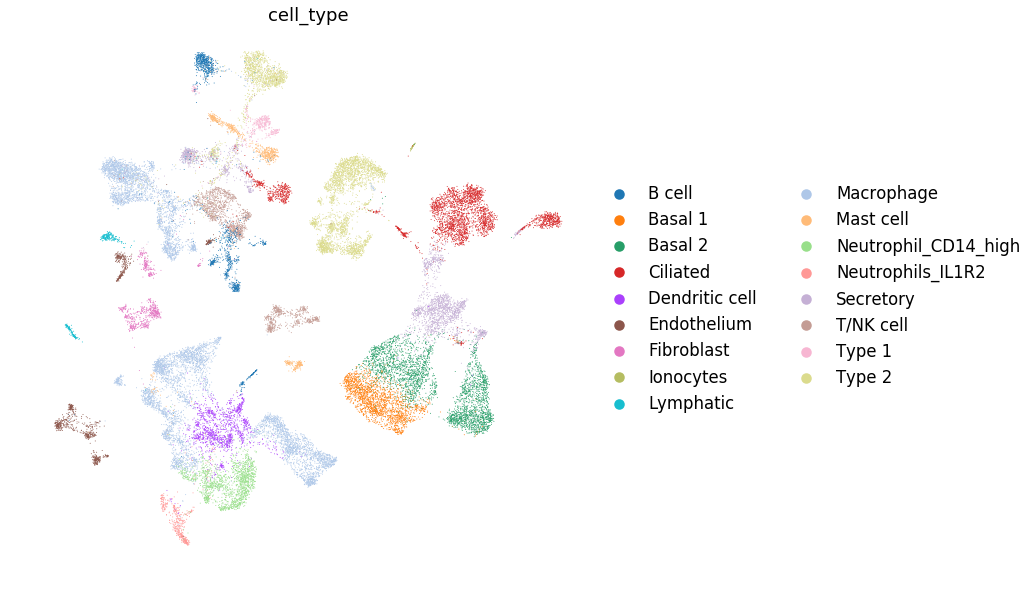

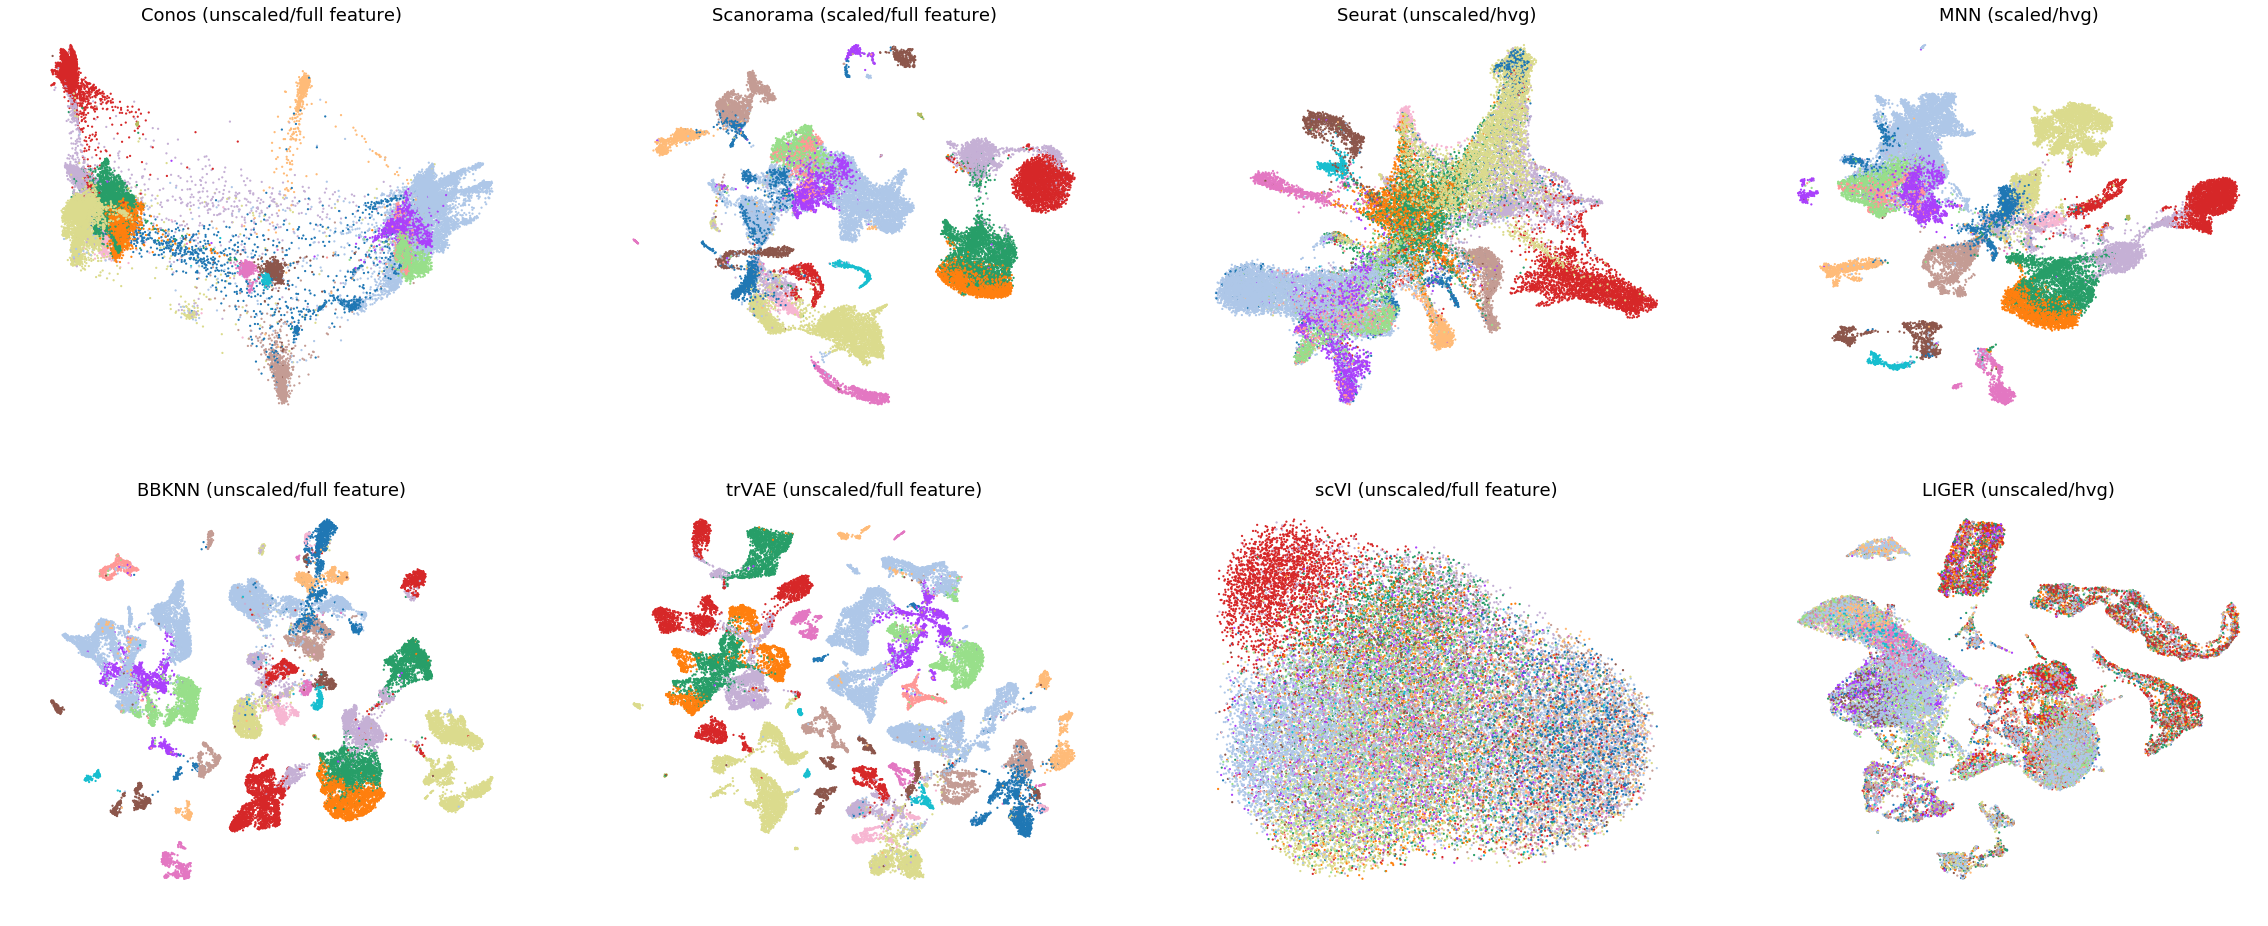

In [150]:
draw_figure(base, lung_pre, lung_best, lung_worst, lung_best_names, lung_worst_names, lung_best_types, lung_worst_types, lung_batch, lung_ct)

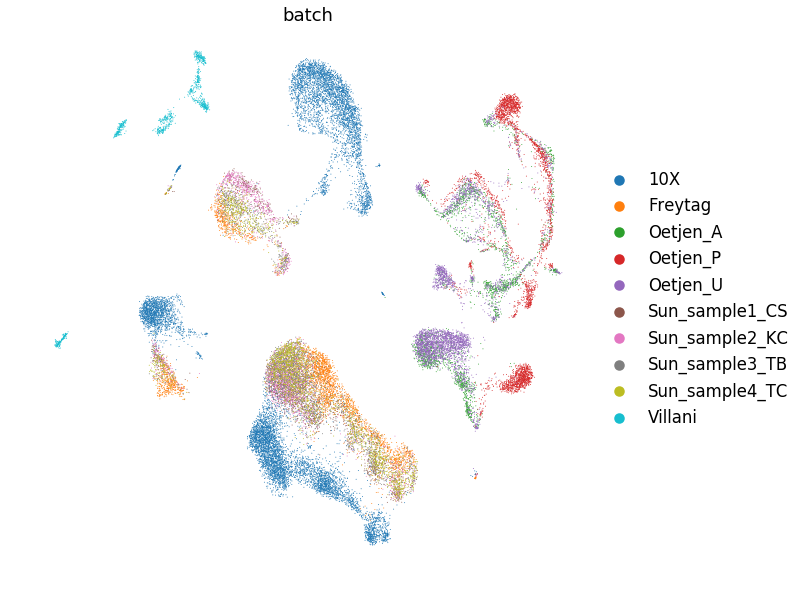

In [127]:
sc.pl.umap(adata_pre, color=batch_key, frameon=False, legend_loc='right margin')

In [97]:
sc.tl.draw_graph(adatas_best['con_uh'][0])

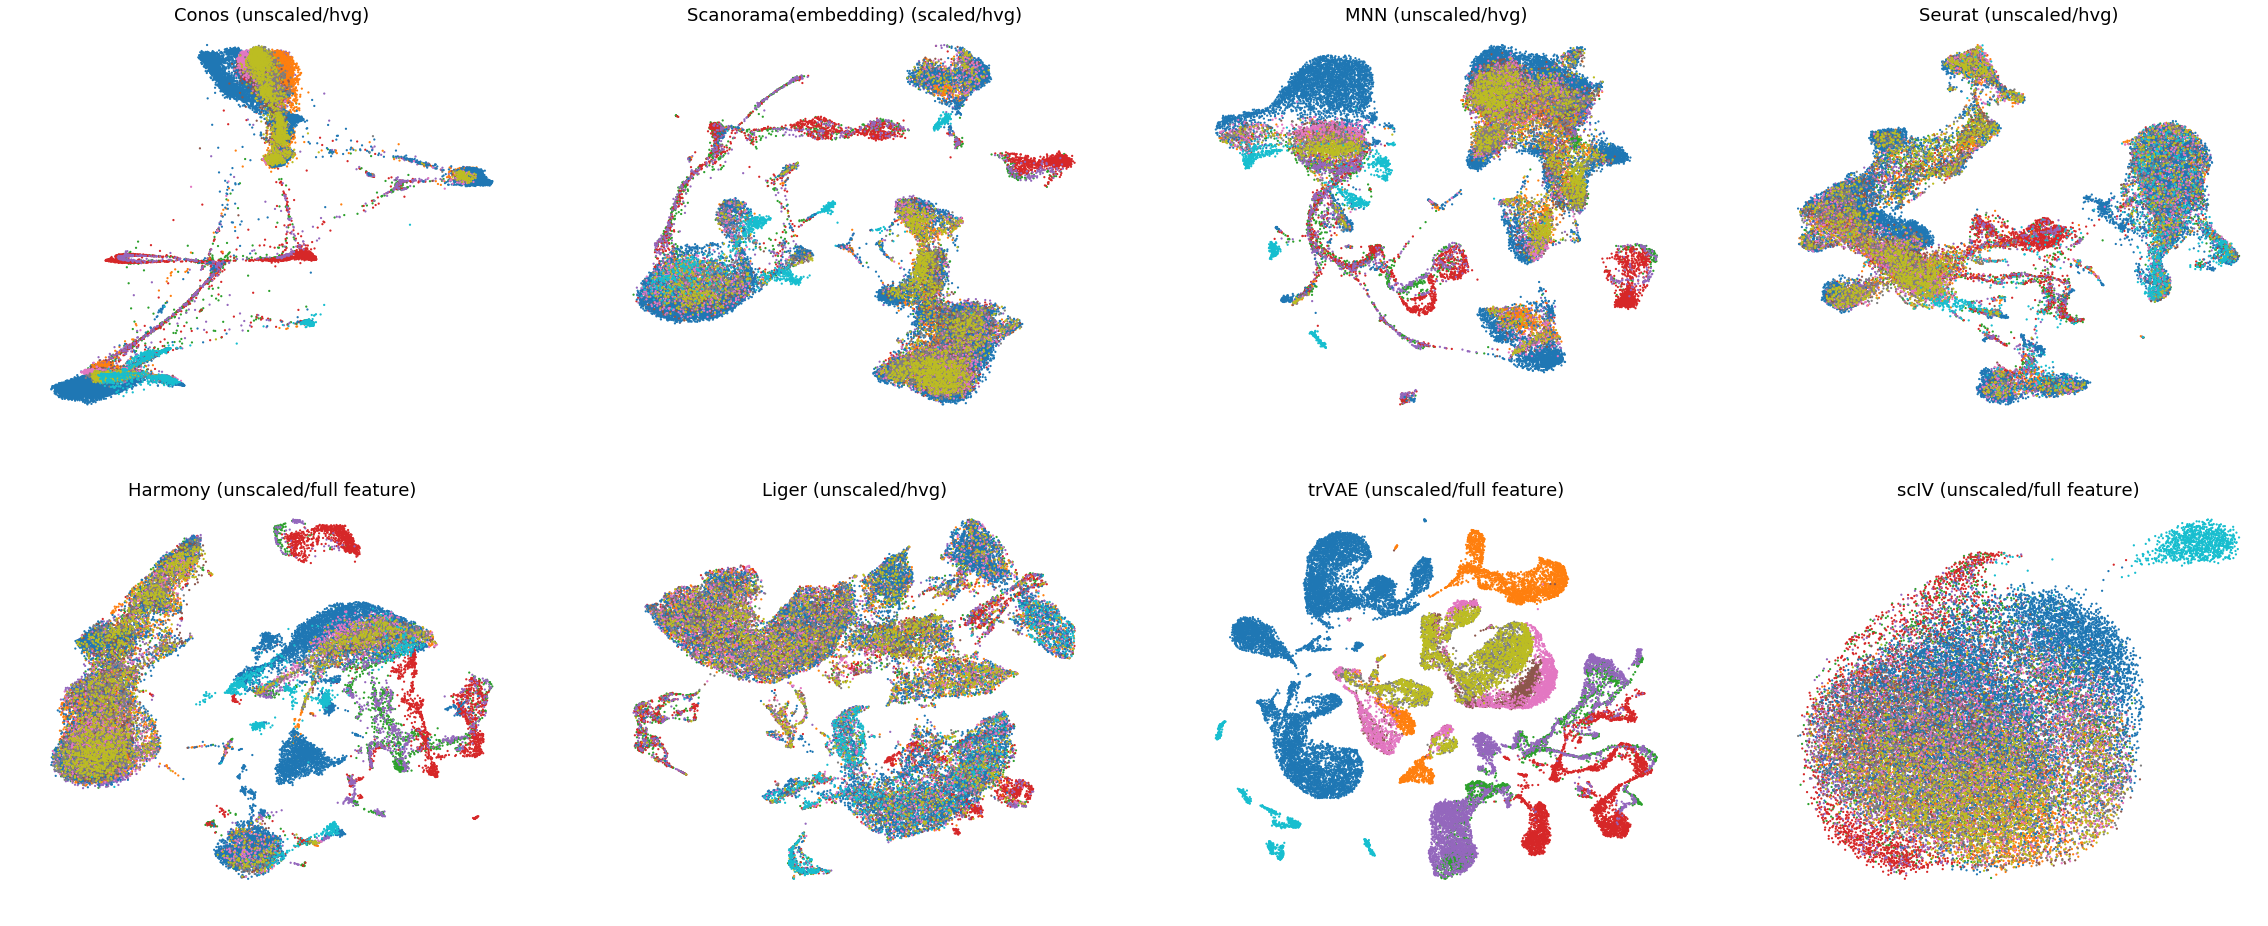

In [125]:
viz(adatas_best, adatas_worst, batch_key)

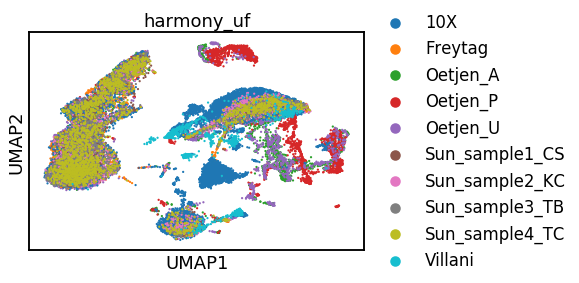

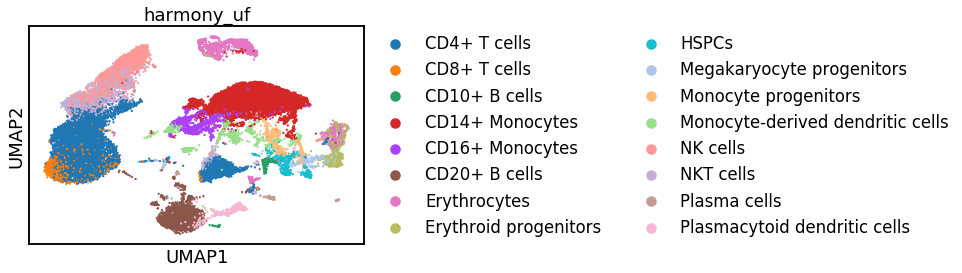

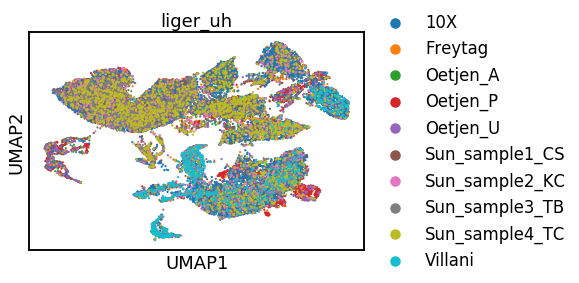

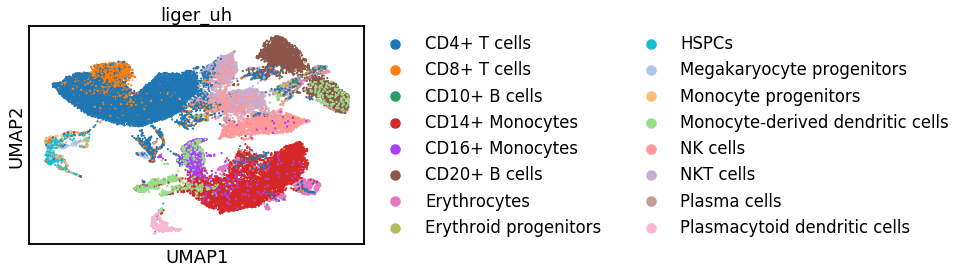

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['X_emb', 'reconstructed']."

In [18]:
viz(adatas_worst)

In [166]:
dat = adatas['con_uh'][0].copy()

In [168]:
dat_diff.uns['neighbors']['connectivities']

<33506x33506 sparse matrix of type '<class 'numpy.float64'>'
	with 18842740 stored elements in Compressed Sparse Row format>

In [172]:
n,_ = connected_components(dat_diff.uns['neighbors']['connectivities'])
n

1

In [173]:
sc.tl.umap(dat)

In [179]:
sc.tl.draw_graph(dat)

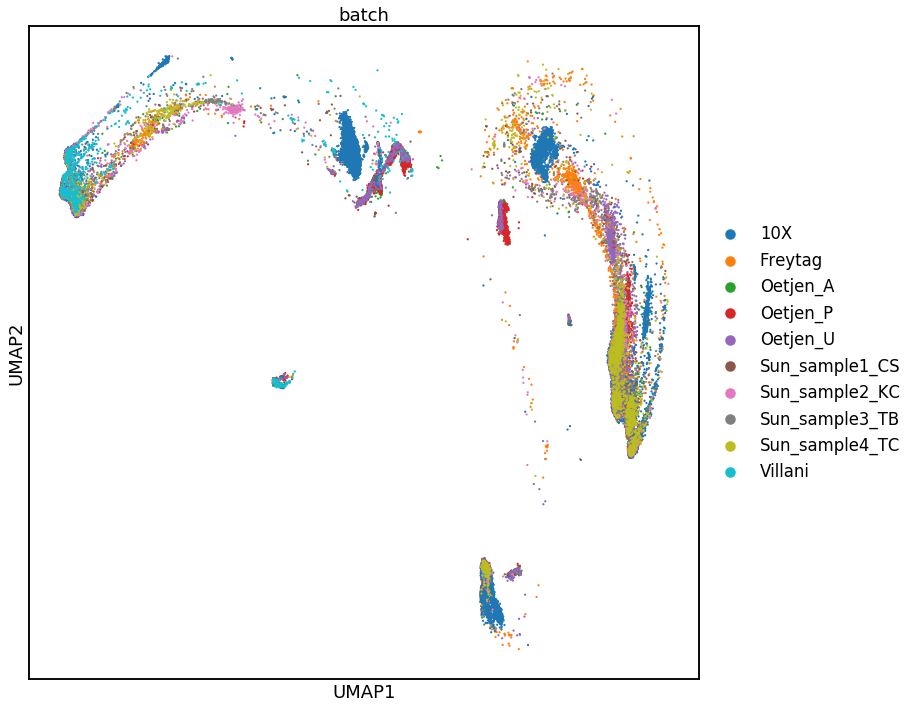

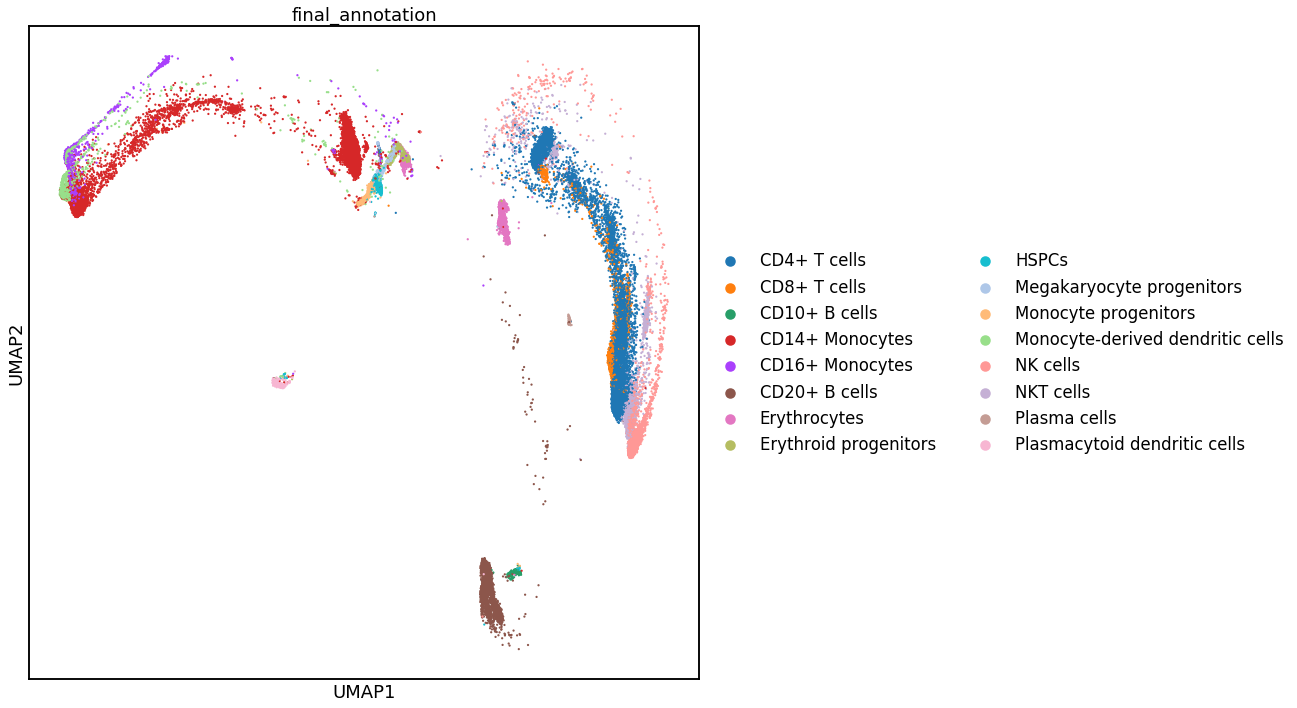

In [182]:
sc.pl.umap(dat, color=batch_key, size=20)
sc.pl.umap(dat, color=ct_key, size=20)

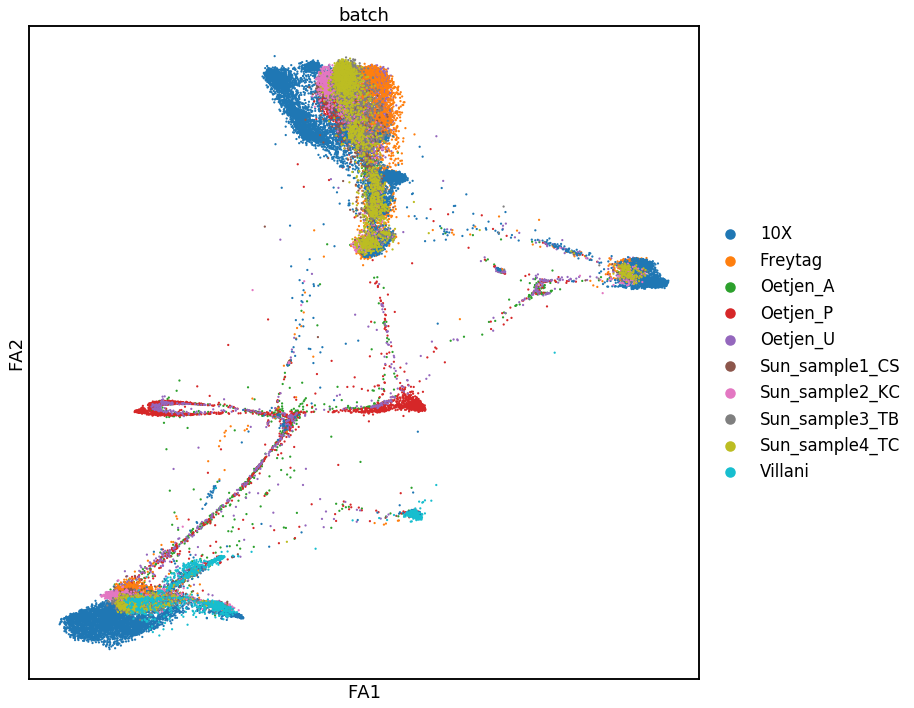

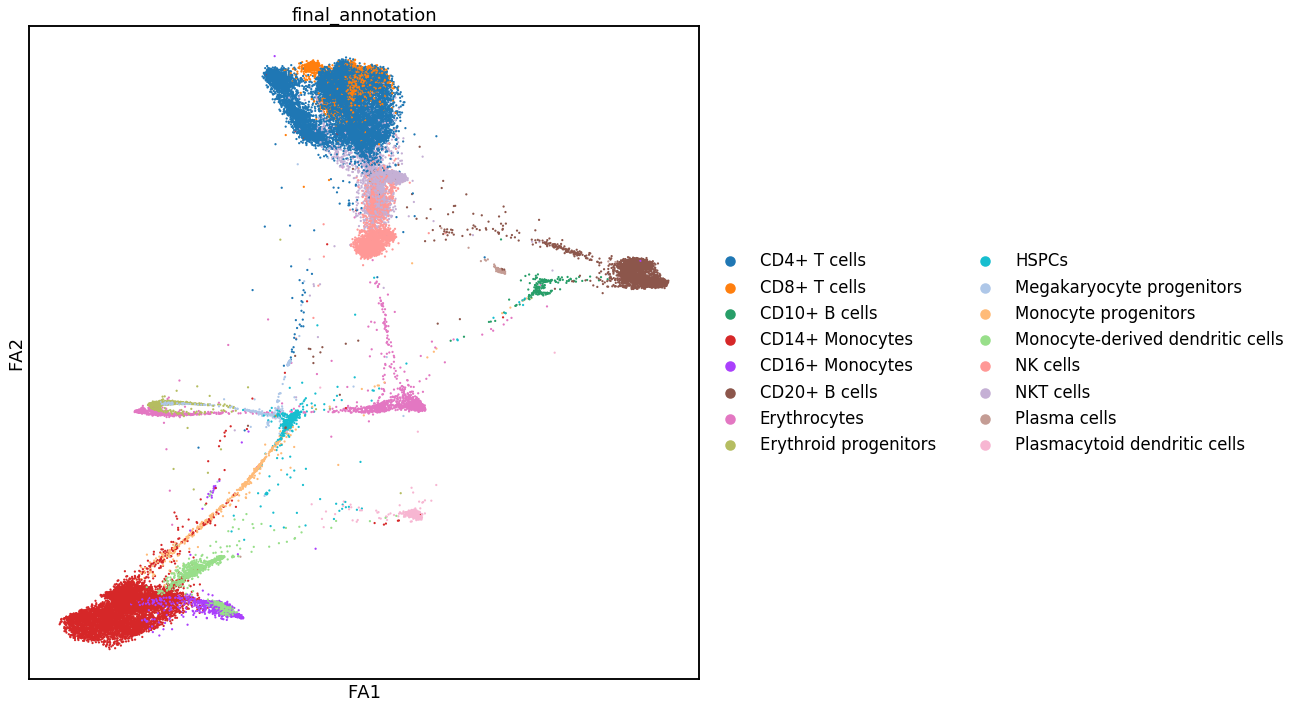

In [181]:
sc.pl.draw_graph(dat, color=batch_key, size=20)
sc.pl.draw_graph(dat, color=ct_key, size=20)

# Check trajectory metric

In [131]:
from scipy.sparse.csgraph import connected_components

In [47]:
adatas.keys()

dict_keys(['con_uh', 'scanE_sh', 'seu_uh', 'scanG_uh', 'mnn_sh'])

In [140]:
def get_root(adata_pre, adata_post, ct_key, dpt_dim=3):
    n_components, adata_post.obs['neighborhood'] = connected_components(csgraph=adata_post.uns['neighbors']['connectivities'], directed=False, return_labels=True)

    start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
    min_dpt = np.flatnonzero(adata_pre.obs[ct_key] == start_clust)
    max_neigh = np.flatnonzero(adata_post.obs['neighborhood']== adata_post.obs['neighborhood'].value_counts().argmax())
    min_dpt = [value for value in min_dpt if value in max_neigh]

    # compute Diffmap for adata_post                                                                                                                                                                                                                                                                              
    sc.tl.diffmap(adata_post)

    # determine most extreme cell in adata_post Diffmap                                                                                                                                                                                                                                                           
    min_dpt_cell = np.zeros(len(min_dpt))
    for dim in np.arange(dpt_dim):

        diffmap_mean = adata_post.obsm["X_diffmap"][:, dim].mean()
        diffmap_min_dpt = adata_post.obsm["X_diffmap"][min_dpt, dim]

        # choose optimum function                                                                                                                                                                                                                                                                                 
        if diffmap_min_dpt.mean() < diffmap_mean:
            opt = np.argmin
        else:
            opt = np.argmax
        # count opt cell                                                                                                                                                                                                                                                                                          
        min_dpt_cell[opt(diffmap_min_dpt)] += 1

    # root cell is cell with max vote                                                                                                                                                                                                                                                                             
    return min_dpt[np.argmax(min_dpt_cell)]

In [133]:
tmp = adatas['scanE_'][0].copy()

In [134]:
cell_sub = adata_pre.obs.index[adata_pre.obs["dpt_pseudotime"].notnull()]

In [135]:
adata_pre_sub = adata_pre[cell_sub]
tmp_sub = tmp[cell_sub]

In [136]:
adata_pre
adata_pre_sub
tmp
tmp_sub

AnnData object with n_obs × n_vars = 33506 × 12303 
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

View of AnnData object with n_obs × n_vars = 2629 × 12303 
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

AnnData object with n_obs × n_vars = 33506 × 2000 
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'nCount_RNA', 'nFeature_RNA', 'ident'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'batch_colors', 'final_annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

View of AnnData object with n_obs × n_vars = 2629 × 2000 
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'nCount_RNA', 'nFeature_RNA', 'ident'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'batch_colors', 'final_annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [141]:
tmp_sub.uns['iroot'] = get_root(adata_pre_sub, tmp_sub, ct_key=ct_key)

Trying to set attribute `.obs` of view, copying.
/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:754: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0/q, 0, W.shape[0], W.shape[0])
/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:764: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0/z, 0, K.shape[0], K.shape[0])


In [142]:
sc.tl.dpt(tmp_sub)

In [143]:
tmp_sub.obs['dpt_pseudotime'][tmp_sub.obs['dpt_pseudotime']>1]=0

/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
tmp_sub.uns['iroot']

365

In [147]:
root_vec = [0]*tmp_sub.n_obs
root_vec[365] = 1
tmp_sub.obs['root'] = root_vec

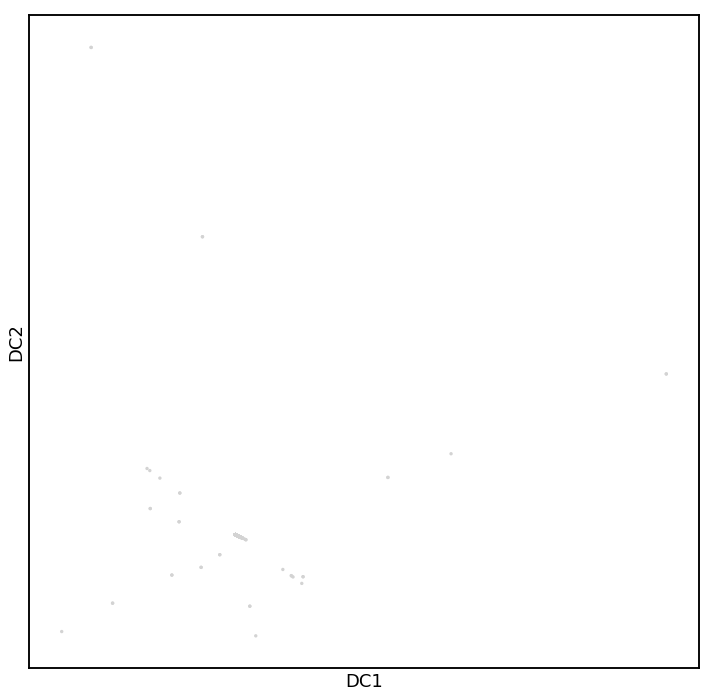

In [148]:
sc.pl.diffmap(tmp_sub)

In [149]:
tmp_sub.obsm['X_diffmap']

array([[-7.10161496e-03,  2.51258584e-03, -1.11968594e-03, ...,
         0.00000000e+00, -2.96441712e-17,  1.35650581e-17],
       [-1.06158378e-02,  3.75593454e-03, -1.67376071e-03, ...,
         1.21430643e-17,  2.60653329e-17, -2.03989902e-17],
       [-2.29279026e-02,  8.11200310e-03, -3.61495954e-03, ...,
         4.85722573e-17,  6.54323820e-17,  2.67533080e-16],
       ...,
       [-7.55780842e-03,  2.67398916e-03, -1.19161233e-03, ...,
         3.46944695e-18, -1.22496987e-17, -5.86556213e-18],
       [-8.29276722e-03,  2.93402118e-03, -1.30749063e-03, ...,
        -2.08166817e-17, -1.49106800e-17,  1.03220502e-17],
       [-1.43609615e-02,  5.08097792e-03, -2.26424099e-03, ...,
         1.73472348e-18,  5.68971089e-17, -2.31370544e-16]], dtype=float32)

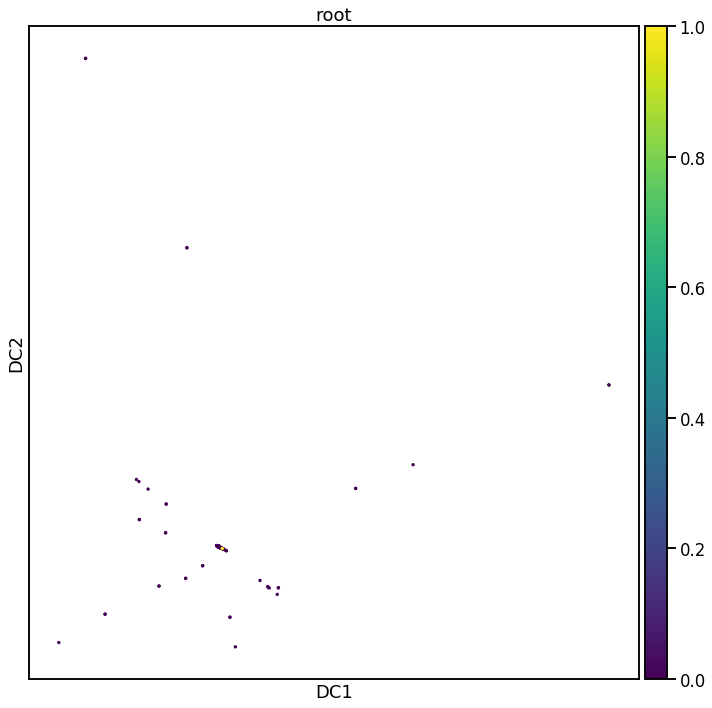

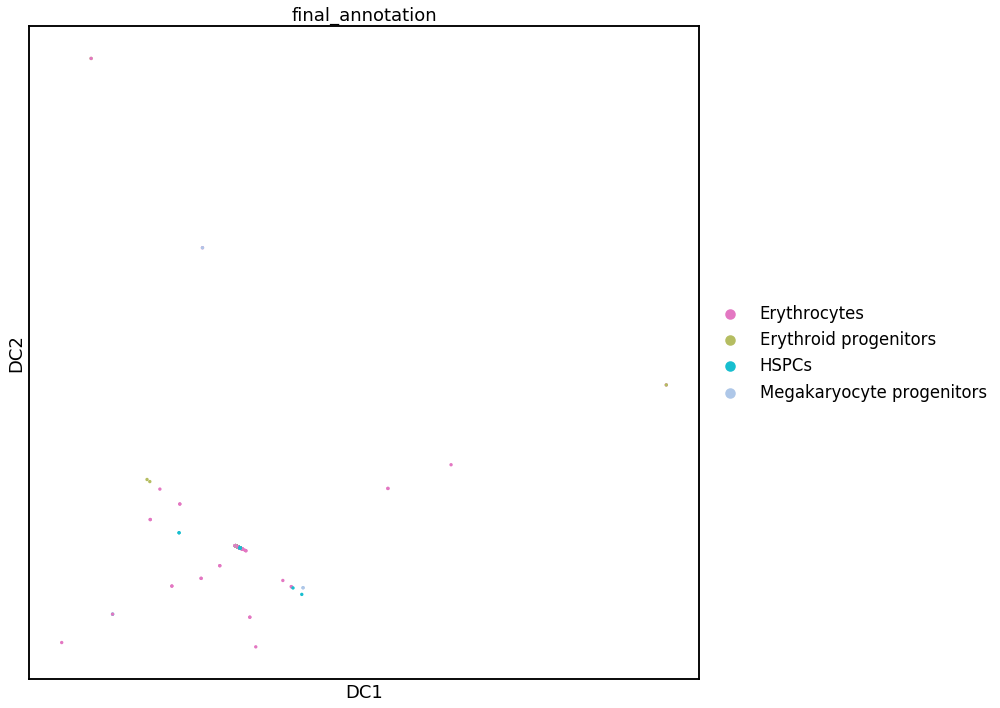

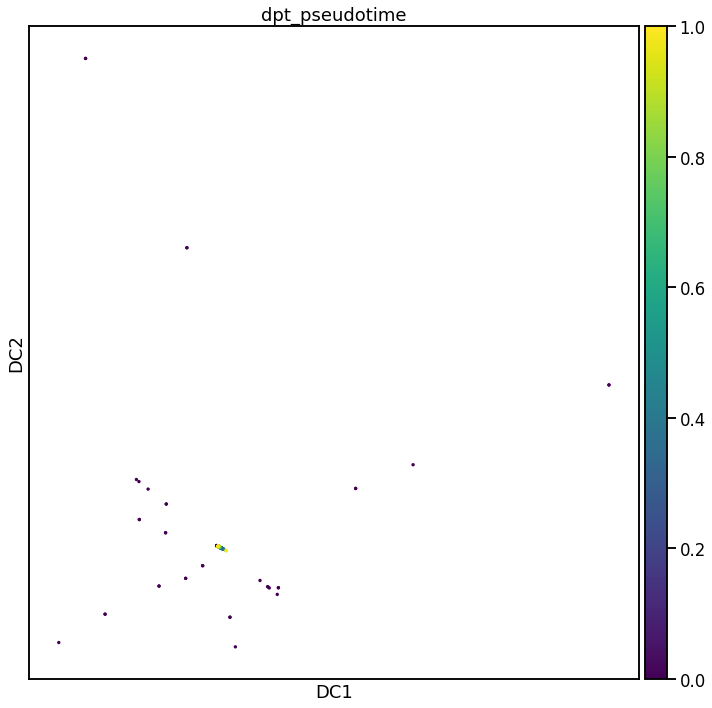

In [150]:
sc.pl.diffmap(tmp_sub, color='root')
sc.pl.diffmap(tmp_sub, color=ct_key)
sc.pl.diffmap(tmp_sub, color='dpt_pseudotime')

In [122]:
tmp_sub.obs['dpt_pseudotime']

index
AAACGGGCACCTCGGA-1-Oetjen_A    inf
AAACGGGCACGGATAG-1-Oetjen_A    inf
AAACGGGGTTTGACTG-1-Oetjen_A    inf
AACACGTTCCAAACAC-1-Oetjen_A    inf
AACCGCGTCATCTGTT-1-Oetjen_A    inf
                              ... 
TTTATGCAGCCATCGC-1-Oetjen_U    inf
TTTCCTCGTTGGTTTG-1-Oetjen_U    inf
TTTGCGCCAGCTTAAC-1-Oetjen_U    inf
TTTGCGCTCAAGGCTT-1-Oetjen_U    inf
TTTGTCAAGACATAAC-1-Oetjen_U    inf
Name: dpt_pseudotime, Length: 2629, dtype: float32

In [116]:
tmp_sub.obs['old_pseudotime'] = adata_pre_sub.obs['dpt_pseudotime']
tmp_sub.obs['old_pseudotime_root'] = adata_pre_sub.obs['dpt_pseudotime'] == 0

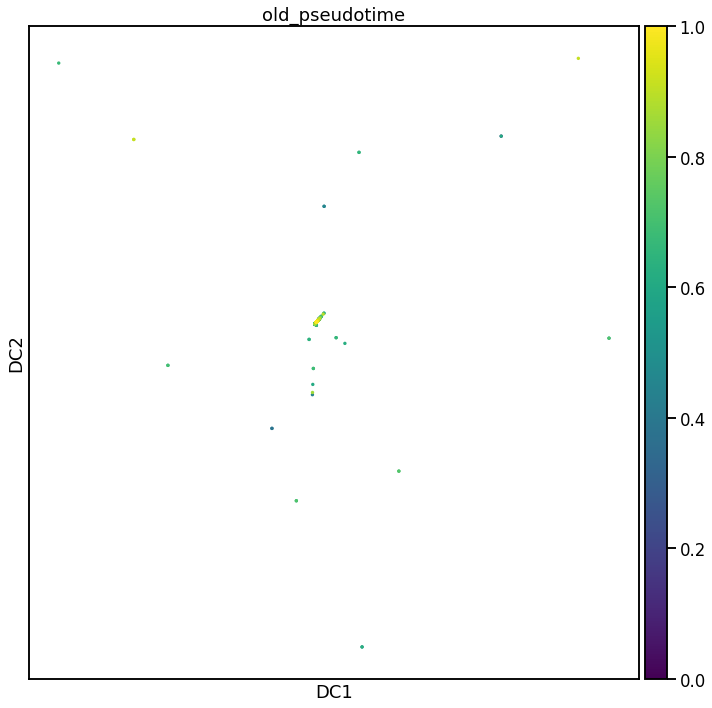

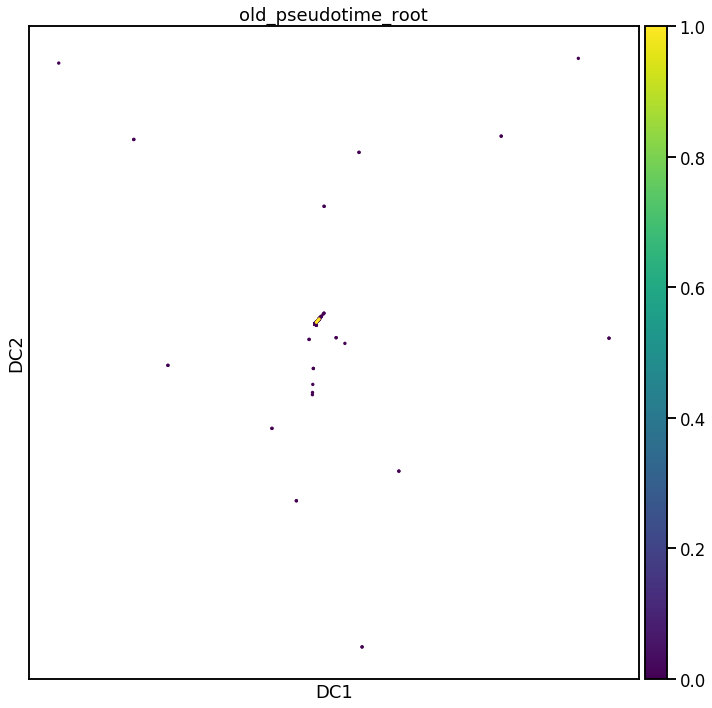

In [117]:
sc.pl.diffmap(tmp_sub, color='old_pseudotime')
sc.pl.diffmap(tmp_sub, color='old_pseudotime_root')

In [86]:
start_clust = adata_pre.obs.groupby(['final_annotation']).mean()['dpt_pseudotime'].idxmin()

In [87]:
min_dpt = np.flatnonzero(adata_pre.obs["final_annotation"] == start_clust)

In [81]:
min_dpt = np.flatnonzero(adata_pre.obs["dpt_pseudotime"] == 0)

In [82]:
min_dpt

array([2458, 4371, 5886])

In [83]:
type(min_dpt)

numpy.ndarray

In [ ]:
import gc

In [ ]:
adata = sc.read(file)
adata_pre = sc.read(file)

In [ ]:
if len(set(adata_pre.obs_names).difference(set(adata.obs_names))) > 0:
    new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata.obs_names]
    if len(set(adata_pre.obs_names).difference(set(new_obs_names))) == 0:
        adata.obs_names = new_obs_names
    else:
        raise ValueError('obs_names changed after integration!')
        
adata.obs[batch_key] = adata.obs[batch_key].astype('category')

if not np.array_equal(adata_pre.obs[batch_key].cat.categories,adata.obs[batch_key].cat.categories):
    adata.obs[batch_key] = adata_pre.obs[batch_key]


In [ ]:
del adata_pre
del adata.layers['counts']
gc.collect()

scIB.pp.reduce_data(adata, ...)
del adata.obsm['X_pca']
if type_ == 'embed':
    del adata.obsm['X_emb']

#call python garbage collector
gc.collect()

# Do kBEt
# Do 


In [151]:
(tmp_sub.obs['dpt_pseudotime'].corr(adata_pre_sub.obs['dpt_pseudotime'], 'spearman')+1)/2

0.6791380444351764